In [564]:
# Gonna look at for a random signal
import jax.numpy as np
import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax
import jax.random as jr
from scipy.special import jv
import zodiax as zdx
import optax
from tqdm import tqdm
from scipy.stats import binned_statistic

In [565]:
diameter = 0.125
period = 304e-6

In [566]:
N = 1024              # number of samples
dx = 0.001 * 10*10**(-9) # wavelength spacing, for ~ 1000 samples in 10 nm
fs = 1 / dx           # sampling frequency
freqs = np.fft.fftfreq(N, d=dx)

min_wavelength = 580e-9

# Desired frequency band (in Hz)
f_low = 0

max_spec_freq = (np.sqrt(2)/period) * (diameter/min_wavelength)

f_high = 4*max_spec_freq


In [570]:
key = jr.PRNGKey(19)

# Create a complex array of zeros
spectrum = np.zeros(N, dtype=np.complex64)

# Get indices of freqs within band (positive freqs only)
band_mask = (freqs >= f_low) & (freqs <= f_high)

# Random amplitudes and phases
amp_key, phase_key = jr.split(key)
random_amplitudes = jr.normal(amp_key, shape=(N,)) * band_mask
random_phases = jr.uniform(phase_key, shape=(N,), minval=0.0, maxval=2 * np.pi)

# Assign complex values
spectrum = random_amplitudes * np.exp(1j * random_phases)

# Make symmetric to ensure real time-domain signal
# Copy positive freqs into negative side
def make_hermitian(spec):
    spec = spec.at[1:N//2].set(spec[1:N//2])
    spec = spec.at[-(N//2)+1:].set(np.conj(spec[1:N//2][::-1]))
    return spec

spectrum = make_hermitian(spectrum)


In [571]:
signal = np.fft.ifft(spectrum).real
spectrum_filtered = spectrum.at[np.abs(freqs) > max_spec_freq].set(0)
signal_filtered = np.fft.ifft(spectrum_filtered).real

if np.min(signal) <= 0:
    signal_filtered += -2*np.min(signal)
    signal += -2*np.min(signal)

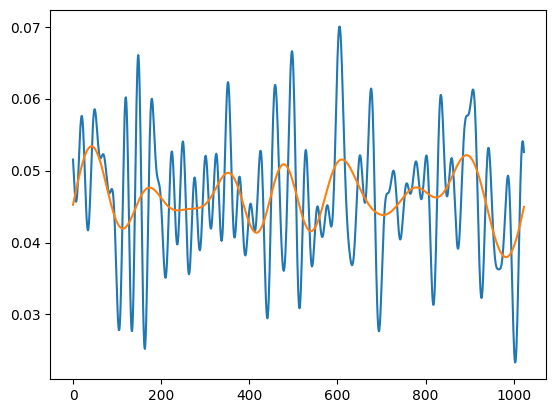

In [572]:
plt.plot(signal)
plt.plot(signal_filtered)
plt.show()

In [573]:
wavelengths = np.linspace(min_wavelength, min_wavelength+N*dx, N)

nyquist_sample_interval = 1/(2*max_spec_freq)

sample_interval = 0.4*nyquist_sample_interval #quarter nyquist

n_wavelengths_sample = int(np.ceil(((N+2)*dx)/sample_interval))

print(n_wavelengths_sample)

wavelengths_sample = np.linspace(580e-9 - sample_interval, 580e-9 + sample_interval*(n_wavelengths_sample-1), n_wavelengths_sample)
print(wavelengths_sample[-1])

weights_initial = np.ones(n_wavelengths_sample) # log weights, but init at 1

flux = 10000*(2.909*10**7)/11
difference = np.pi * 0.348
flux_renorm = flux #/(jv(0, difference/4)**2 * jv(1, difference/4)**2)

source = dl.PointSource(wavelengths, flux=flux_renorm, weights=signal)

source_filtered = dl.PointSource(wavelengths, flux=flux_renorm, weights=signal_filtered)

source_model = dl.PointSource(wavelengths_sample, flux=flux_renorm, weights=weights_initial)

wf_npixels = 128 # 128 lowest power of 2 necessary

apertureLayer = dlT.TolimanApertureLayer(wf_npixels)

layers = [
    (
        'aperture',
        apertureLayer
    )
]

psf_npixels = 64
psf_pixel_scale = 0.375
oversample = 4 # 4 seems good

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,psf_pixel_scale,oversample)

center_wl = 585e-9

telescope = dl.Telescope(optics, source)
telescope_filtered = dl.Telescope(optics, source_filtered)
telescope_model = dl.Telescope(optics, source_model)

sidelobescope = dlT.SideLobeTelescope(telescope, period, difference)
sidelobescope_filtered = dlT.SideLobeTelescope(telescope_filtered, period, difference)
sidelobescope_model = dlT.SideLobeTelescope(telescope_model, period, difference)

sidelobe_raw = sidelobescope.model_sidelobes(center_wavelength = center_wl, downsample = oversample)
sidelobe_filtered_raw = sidelobescope_filtered.model_sidelobes(center_wavelength = center_wl, downsample=oversample)

sidelobe_poisson = jr.poisson(jr.PRNGKey(0), sidelobe_raw)

52
5.9017367e-07
Model time: 18.1408 seconds.
Model time: 16.2788 seconds.


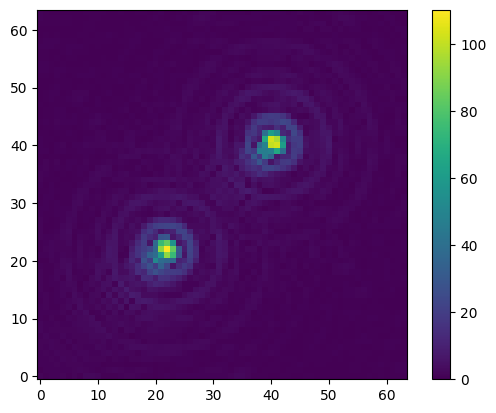

In [574]:
plt.imshow(np.abs(sidelobe_raw - sidelobe_filtered_raw)**0.5, origin='lower')
plt.colorbar()
plt.show()
# WOW. So you can clearly see that there is no difference (except on the edges) between sending a filtered signal
# and another higher frequency signal in.
# The maths actually works out!!

In [575]:
weights_path = 'telescope.source.spectrum.weights'

parameters = [weights_path]

# initial guess for weights, uniform ones!
#model = sidelobescope.set(weights_path, np.ones(n_lambda)/n_lambda)
# new oversampled model
model = sidelobescope_model

# Optimisation
# 10% initial learning rate.
weights_optimiser = optax.adam(0.5)

optimisers = [weights_optimiser]

optim, opt_state = zdx.get_optimiser(model, parameters, optimisers)

In [576]:
@zdx.filter_jit
@zdx.filter_value_and_grad(parameters)
def loss_fn(model, data):
    # LOG WEIGHTS OPTIMISATION: THIS MAKES IT SOOOO MUCH BETTER!!!
    log_weights = model.get(weights_path)
    weights = np.exp(log_weights)
    model = model.set(weights_path, weights)
    out = model.model_sidelobes(center_wavelength = center_wl, downsample = oversample)
    #return np.sum((data-out)**2)
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))

In [577]:
losses, models_out = [], []
n_iter = 400
with tqdm(range(n_iter),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(model, sidelobe_poisson)

        updates, opt_state = optim.update(grads, opt_state)

        # just do log weight optimisation
        model = zdx.apply_updates(model, updates)
        losses.append(loss)
        models_out.append(model)
        t.set_description("Log Loss: {:.3f}".format(np.log10(loss))) # update the progress bar

Gradient Descent:   0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.7891 seconds.


Log Loss: 4.382: 100%|██████████| 400/400 [00:30<00:00, 13.02it/s]


In [578]:
model_log_weights = models_out[-1].weights
model_weights = np.exp(model_log_weights)
final_model = models_out[-1].set(weights_path, model_weights)
model_psf = final_model.model_sidelobes(center_wavelength = center_wl, downsample=oversample)


Model time: 0.9213 seconds.


In [579]:
print(model_weights)

[0.07417705 0.4141738  1.8629478  1.6735693  1.348223   1.2321405
 1.3795799  1.5382321  1.235429   0.9027043  1.8605253  1.4037197
 1.4176624  0.91191655 1.3473665  1.7650598  1.2674478  1.1289699
 1.4724119  1.7120291  1.3569709  1.0868691  1.1460876  1.6509929
 1.3923888  1.3466908  1.5446088  1.3122406  1.1024456  1.2915808
 1.6557786  1.6367344  1.2662139  1.3322407  1.5960466  1.3038173
 1.1848891  1.3270525  1.3884517  1.5251242  1.3841166  1.2877874
 1.3829591  1.5359429  1.5045781  1.5349464  1.3622007  1.636272
 0.92299896 1.4216359  0.9656453  1.1277511 ]


In [580]:
def sinc_interp(xi, x, y):
    # xi: new points, x: original, y: filtered signal
    sinc_matrix = np.sinc((xi[:, None] - x[None, :]) / sample_interval)
    return sinc_matrix @ y  # shape: (len(xi),)

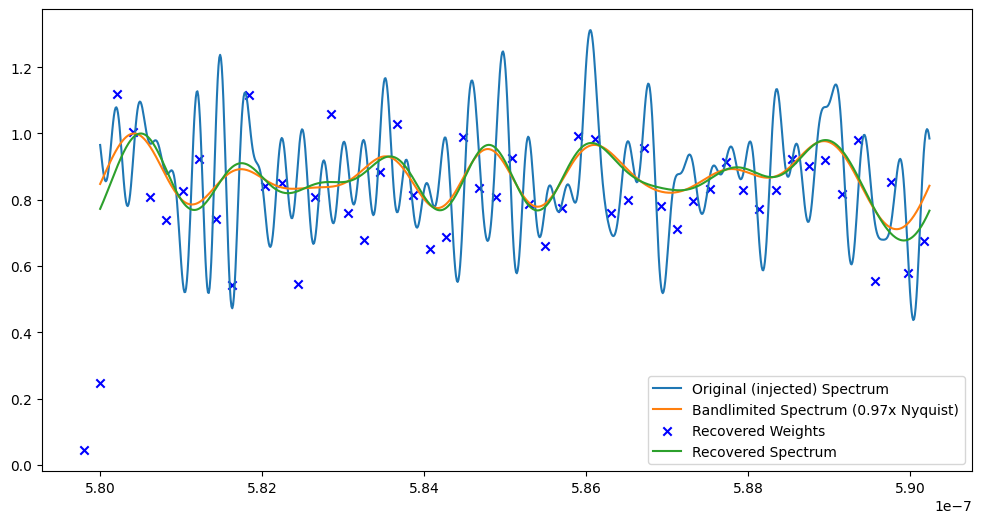

In [586]:
weights_reconstructed = sinc_interp(wavelengths, wavelengths_sample, model_weights)

weights_r_ft = np.fft.fft(weights_reconstructed)

# just realised sample rate is actually sample interval, not a rate
signal_filtered_ft = np.fft.fft(signal_filtered)

alpha = 1 # 0.8 with 100 exposures characterises the middle well? yes.. even more so for lower alpha.
# sometimes really good even for alpha=1!! very exciting. This is very. VERY. VERY COOL!
# above was for 4x nyquist... how about 2x nyquist?
# oh my golly goodness even with a mere 2x nyquist we're recovering it very well. whats going on
# although can be iffy.. (works very well upto 0.9 but by 1 its a bit weird) gonna try 2.5x nyquist.
# 2.5 seems to work well upto 0.97x nyquist. probably where noise comes in too much
# wow this is cool though.
# trying to 'cheat' almost and go to 1.0 nyquist sampling... doesn't work out too well.
# 2.5x nyquist is common in science though I believe. and it works well here.
# 0.97 may have been an illusion, reality is that there are appx no freqs between 0.9 and 0.98 = 1.
signal_filtered_ft_filter2 = signal_filtered_ft.at[np.abs(freqs) > alpha*max_spec_freq].set(0)
weights_r_ft_filtered = weights_r_ft.at[np.abs(freqs) > alpha*max_spec_freq].set(0)

signal_filtered_filter2 = np.fft.ifft(signal_filtered_ft_filter2).real
weights_r_filtered = np.fft.ifft(weights_r_ft_filtered).real

#plt.plot(wavelengths, weights_reconstructed)
#plt.plot(wavelengths, signal_filtered/np.max(signal_filtered))
#plt.plot(wavelengths_sample, 2.3*model_weights/np.max(model_weights))
plt.figure(figsize=(12,6))
plt.plot(wavelengths, signal/np.max(signal_filtered_filter2), label='Original (injected) Spectrum')
plt.plot(wavelengths, signal_filtered_filter2/np.max(signal_filtered_filter2), label='Bandlimited Spectrum (0.97x Nyquist)')
plt.scatter(wavelengths_sample, 0.6*model_weights, marker='x', color='blue', label='Recovered Weights')
plt.plot(wavelengths, weights_r_filtered/np.max(weights_r_filtered), label='Recovered Spectrum')
#plt.plot(wavelengths_sample, model_weights/np.max(model_weights))
#plt.plot(wavelengths, signal/np.max(signal_filtered))
plt.legend()
plt.show()
# cool its pretty good. What if we sample at 8x nyquist though? or what if we introduce some noise?

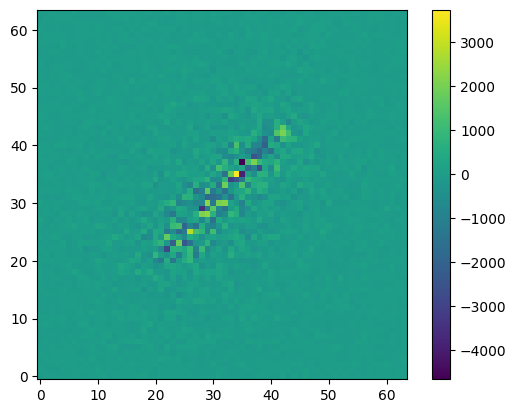

In [582]:
plt.imshow(model_psf - sidelobe_poisson, origin='lower')
plt.colorbar()
plt.show()

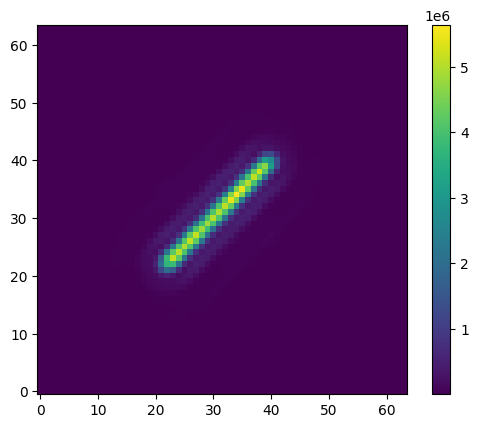

In [490]:
plt.imshow(sidelobe_poisson,origin='lower')
plt.colorbar()
plt.show()